| ![Logo](images/unilogo.png) |
|----------------------------------------------------------------------------|
| University of Greifswald physics department |

X-ray Photoelectron Spectroscopy Lab
===============================================
Authored by: [Nathan Belmore](https://plasma.physics.berkeley.edu/faculty-staff/nathan-belmore) 
In partnership with Tobias Tubandt


# Abstract
***
X-ray Photoelectron Spectroscopy (XPS) is a method for analyzing the surface structure of materials. XPS is widely used because it can identify both elemental composition and chemical bonding states without destroying the sample. In this lab we measured various elements using XPS. We applied layers of chromium to a sample and measured the results of XPS after each application.


# Physical Principles
***
We use x-ray radiation to emit photoelectrons from a sample. Typically we use $MgK\alpha$ ($1253.6$eV) and $AlK\alpha$ ($1486.6$eV) as sources for the x-ray radiation. The outer photo electric effect can be described from the equation below, where $h\nu$ is the energy of the x-ray emission of the source, $E_b$ the binding energy of a electron in the sample and $E_k$ the kinetic energy of the electron that is emitting.

\begin{align}
E_k = h\nu + E_b
\label{eq1}
\end{align}

Also it is possible to emit so called auger electrons, which are pictured in fig. 1.

| ![Manual1](images/manual1.png) |
|----------------------------------------------------------------------------|
| Fig. 1 Display of the outer photo electric effect, while emitting a electron (left) and also an auger electron (right). [1] |

The binding energy provides information about the element in the used sample. Using XPS, it is possible to measure concentration of elements on the surface. XPS can also examine elements below the surface layer. If you examine the mean free path $\lambda_e$ of the photoelectrons, $\lambda_e$ is usually several nanometers and is not dependent on the material of the sample or kinetic energy of the electrons. In the measurements only photoelectrons that are not loosing energy through other collisions contribute to the wanted peak. The maximum depth of information $x$ can be estimated through a exponential decay of the electron intensity $I$.

\begin{align}
I= I_0 \exp{ \left(-\frac{x}{\lambda_e} \right)}
\end{align}

## Chemical Compounds

Not only the the composition of the element can be measured, but also informations about the chemical boundary states can be extracted. The samples  must differ in electro negativity. This result in a chemical shift of the binding energy and directly corresponds to the boundary states. A fit algorithm is used to determine the exact binding energy, $E_b$, which is typically quite small. For example, in the fig. 2, the binding energies for different elements is shown.

| ![Manual2](images/manual2.png) |
|----------------------------------------------------------------------------|
| Fig. 2 Table of different elements and their corresponding binding energies. [1] |

# Execution and Setup
***
Fig. 3 shows the schematic of the experiment. We are using a ultra high vacuum chamber to contain the sample. We emit photoelectrons from the sample via radiative interaction. Through a lock we are able to put the sample inside the chamber and change it for several measurement cycles. The angle $\sigma$ between x-ray source and detector is set to $54.7^{\circ}$ and the angle $\sigma$ seen in fig. 3 can be chosen freely. We use the angle $\sigma=90^{\circ}$ to maximize probe deeper into the sample.

| ![Setup1](images/setup1.png) |
|----------------------------------------------------------------------------|
| Fig. 3 Schematic of the experiment with the UHV chamber, the x-ray source (orange), a detector (green) and the sample on the holder (yellow), which can be adjusted. [1] |

# Analysis
***

In [2]:
# Creating the correct Python enviroment for analysis
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, savgol_filter
import scipy.fftpack
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from lmfit import Model

# Setting parameters to make plots clear for publication
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

## Importing the data

In [3]:
# path to the data set
path = 'data/'

# Importing the intensity data.
# Some data structure for genetrating a list of the files. 
files = []

for file in os.listdir(path):
    if file.endswith(".dat"):
        files.append(os.path.join(path, file))
files.sort()
print('Files imported:')
print(*files, sep='\n')

# Writing the data to the rawdata array.
rawdata = []

for path in files:
    rawdata.append(pd.read_csv(path, sep='\s+', engine='python', names=['energy', 'count']))

    
# The data set is structured in an unfortunate way which complicates importing it.
# The data sets are concatenated with a text header separating them. 
# Below we filter them by set then import them to the data array.
data = []

for k in range(len(rawdata)):
    # Creating a mask to split the data set over the non-numerical data
    mask = pd.to_numeric(rawdata[k].iloc[:,0], errors='coerce').isnull().cumsum()
    
    # Splitting the data using the mask into a new array.
    dfs = [g.rename(columns={0:g.iloc[0].values[0]}).reset_index(drop=True) for i, g in rawdata[k].groupby(mask)]
    
    # Looping over the array
    for j in range(len(dfs)):
        
        # Dropping the non-numeric entries
        dfs[j] = dfs[j][pd.to_numeric(dfs[j]['count'], errors='coerce').notnull()]
        
        # Converting remaining data to float32
        dfs[j] = dfs[j].astype(np.float32)
    
    # Appending dfs array to the data array
    data.append(dfs)

Files imported:
data/TN.1_OR.dat
data/TN.2_OR.dat
data/TN.3_OR.dat
data/TN.4_OR.dat
data/TN.5_OR.dat
data/TN.6_OR.dat


## Task 1: Identify the peaks

We scanned the whole range and identify the peaks. We can see two peaks for Si, which correspond to the speaks of the states $2$p and $2$s. Also the oxygen peaks is clearly visible. The peaks for carbon looks quite low. In the following the peaks are examined more in depth in Task 2 below.

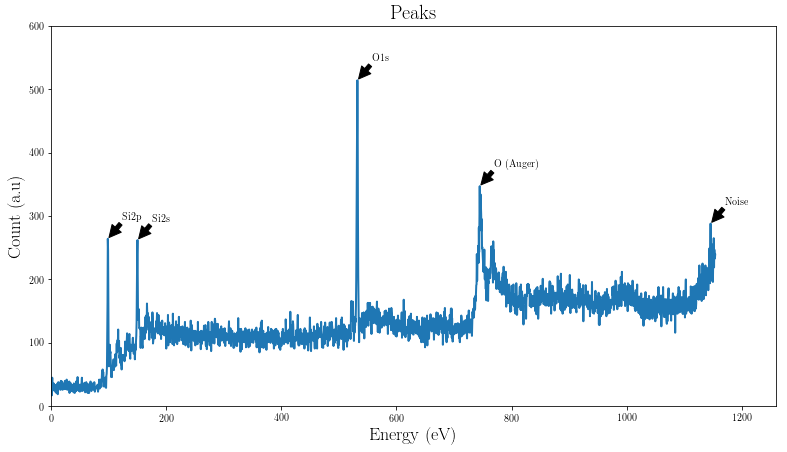

Max values:


energy  count
17    1145.599976  288.0
819    744.599976  347.0
1244   532.099976  514.0
2008   150.100006  262.0
2111    98.599998  264.0

In [8]:
labels = ['Noise', 'O (Auger)', 'O1s', 'Si2s', 'Si2p']

# number of points to be checked before and after 
n=35 

# Find local peaks
max = data[0][0].iloc[argrelextrema(data[0][0]['count'].values, 
                               np.greater_equal, order=n)]

# Dropping peaks outside of range
max = max[max['count'].between(262, 800)]

# Plot results
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_title('Peaks') 
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Count (a.u)')
ax.set_ylim((0,600))
ax.set_xlim((0,1260))
# ax.scatter(data[0][0]['energy'].iloc[max.index.values], 
#            data[0][0]['count'].iloc[max.index.values], c='g')
ax.plot(data[0][0]['energy'], data[0][0]['count'])

# Add labels to points
for h, i in enumerate(max.index.values):
    ax.annotate(labels[h], 
                # x,y of the data points.
                (data[0][0]['energy'][i] + 2, data[0][0]['count'][i] + 2), 
                # Defining the arrows.
                arrowprops=dict(facecolor='black'),
                # Label and arrow orgins.
                xytext=(data[0][0]['energy'][i] + 25, data[0][0]['count'][i] + 30))
plt.show()

print("Max values:")
max

## Task 2: Narrow range of results

As mentioned earlier the concentration of carbon seem to be very low. Just barely above the noise floor. 

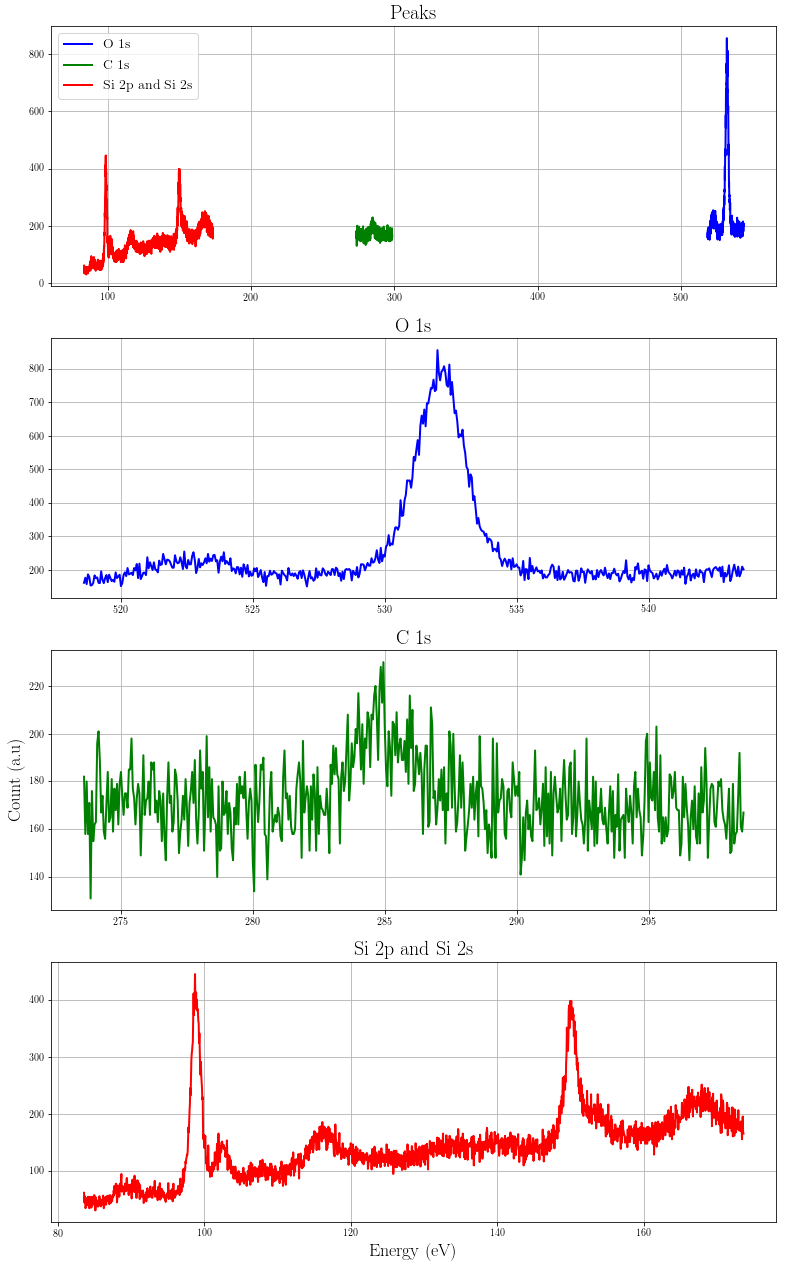

In [4]:
# Plotting the 5 ranges
color = ['b', 'g', 'r', 'c', 'm', 'y']
names = ['O 1s', 'C 1s', 'Si 2p and Si 2s']
fig, ax = plt.subplots(nrows=len(data[1])-1, ncols=1, figsize=(13, 22))


for i in range(len(data[1]) - 2):
    ax[0].plot(data[1][i]['energy'], data[1][i]['count'], color=color[i], label=names[i])
    ax[i+1].plot(data[1][i]['energy'], data[1][i]['count'], color=color[i])
    ax[i+1].set_title(names[i]) 
    ax[i+1].grid(True)

ax[0].grid(True)
ax[0].set_title('Peaks') 
ax[0].legend()
ax[2].set_ylabel('Count (a.u)')
ax[-1].set_xlabel('Energy (eV)')

plt.show()

## Task 3: Applying layers of Chromium

For the purpose of our analysis the physical background of the background shift is not interesting so we calculate a mean for the background and subtract it from the data set. Because both data sets have a second peak to the right of the principle peak, the peaks we want to fit are convolved with the neighboring gaussian. There is a lot of methods to try and account for this convolution but we are going to only fit a subset of the distribution.

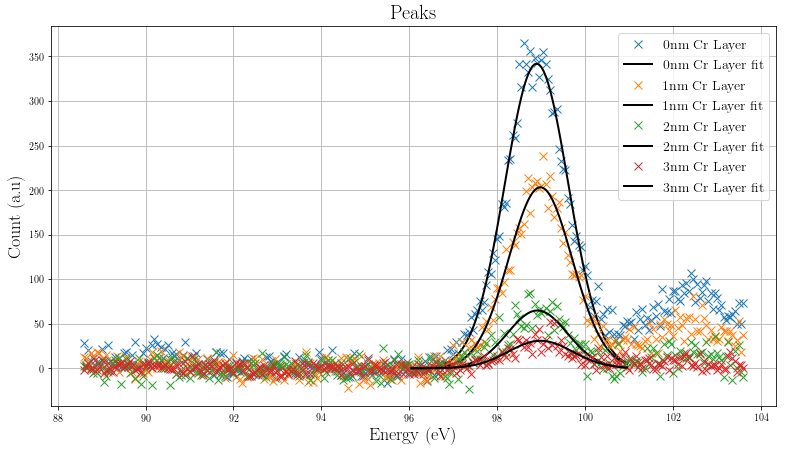

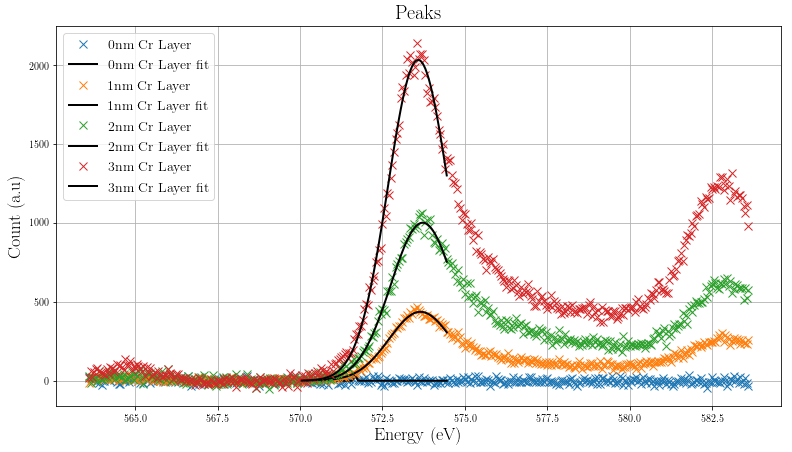

In [21]:
# Function to sample and subtract the noise from the data.
def datanorm(x, y, lower, upper):
    '''Reutrns the mean subtracted data set with the mean value 
    of a subeset defined by a range from lower to upper.'''
    mask = (x > lower) & (x < upper)
    return y - np.mean(y[mask])

# Function we are interested in fitting
def gauss(x, a, x0, sigma):
    '''Classic Gaussian, ymax must be defined external to the
    function call.'''
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Function for alculating the error terms
def proderr(Δx: 'error on x', Δy: 'error on y', x, y):
    '''Calculate the error from taking a product or ratio of x & y'''
    return np.sqrt((Δx/x)**2 + (Δy/y)**2)
    
# Vectors to store fit parameters.
fitparams = []

# Wrap gauss function into a model.
gmodel = Model(gauss)

############# First Plot ############# 
fig, ax = plt.subplots(figsize=(13, 7))

# Select fit range for first data set.
left, right = 96, 101

labels = ['0nm Cr Layer', '1nm Cr Layer', 
          '3nm Cr Layer', '2nm Cr Layer']
fitlabels = ['0nm Cr Layer fit', '1nm Cr Layer fit', 
             '3nm Cr Layer fit', '2nm Cr Layer fit']

for i in [2, 3, 5, 4]:
    x = data[i][0]['energy']
    
    # Shift background to 0, mean noise calculated from 94-96eV.
    y = datanorm(data[i][0]['energy'], data[i][0]['count'], 94, 96)
    
    # Creates a mask to take the fit over.
    mask = (x > left) & (x < right)
    
    # Plotting the data
    ax.plot(x, y, 'x', label=labels[i-2])
    
    # Fits the data to the model.
    result = gmodel.fit(y[mask], x=x[mask], 
                        a=y[mask].max(), x0=x[mask].mean(), sigma=x[mask].std())
    
    # Plots the fit results.
    plt.plot(x[mask], result.best_fit, 'k-', label=fitlabels[i-2])
    
    # Record the fit parameters
    fitparams.append([result.params['a'].value, 
                      result.params['sigma'].value,
                      # The product of the error terms for A and sigma.
                      proderr(result.params['a'].stderr, 
                              result.params['sigma'].stderr,
                                 result.params['a'].value, 
                              result.params['sigma'].value)])

ax.grid(True)
ax.set_title('Peaks') 
ax.set_ylabel('Count (a.u)')
ax.set_xlabel('Energy (eV)')
ax.legend()
plt.show()

#############  Second plot ############# 
fig, ax = plt.subplots(figsize=(13, 7))

# Select fit range for first data set.
left, right = 570, 574.5

labels = ['0nm Cr Layer', '2nm Cr Layer', 
          '1nm Cr Layer', '3nm Cr Layer']
fitlabels = ['0nm Cr Layer fit', '2nm Cr Layer fit', 
             '1nm Cr Layer fit', '3nm Cr Layer fit']

for i in [2, 4, 3, 5]:
    x = data[i][1]['energy']
    
    # Shift background to 0, mean noise calculated from 94-96eV.
    y = datanorm(data[i][1]['energy'], data[i][1]['count'], 567.5, 570)
    
    # Creates a mask to take the fit over.
    mask = (x > left) & (x < right)
    
    # Plotting the data
    ax.plot(x, y, 'x', label=labels[i-2])
    
    # Fits the data to the model.
    result = gmodel.fit(y[mask], x=x[mask], 
                        a=y[mask].max(), x0=x[mask].mean(), sigma=x[mask].std())
    
    # Plots the fit results.
    plt.plot(x[mask], result.best_fit, 'k-', label=fitlabels[i-2])
    
    # Record the fit parameters and the product of the error.
    fitparams.append([result.params['a'].value, 
                      result.params['sigma'].value, 
                      # The product of the error terms for A and sigma.
                      proderr(result.params['a'].stderr, result.params['sigma'].stderr,
                                 result.params['a'].value, result.params['sigma'].value)])

ax.grid(True)
ax.set_title('Peaks') 
ax.set_ylabel('Count (a.u)')
ax.set_xlabel('Energy (eV)')
ax.legend()
plt.show()

To better examine the results of adding layers of Cr we can examine the ratio of the area of the peaks. We expect the ratio to be zero for the $0nm$ measurement and grow sharply as a function of the layer thickness. We are going to calculate the area directly from the fit parameters.

\begin{align}
\int_{-\infty}^{\infty} A e^{-\frac{x^2}{2 \sigma^2}} dx = A \mid \sigma \mid \sqrt{2 \pi}
\end{align}

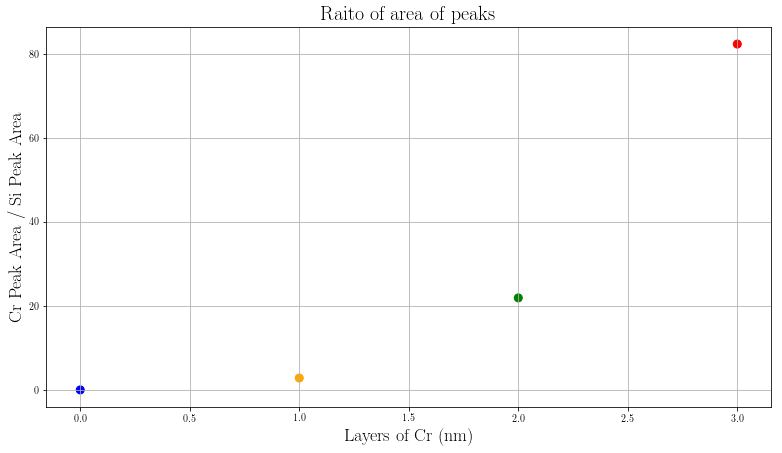

In [22]:
# Calculate the ratio of the areas
x = range(4)
ratio = [(fitparams[i + 4][0]*fitparams[i + 4][1])/
         (fitparams[i][0]*fitparams[i][1]) for i in x]

# The error on the data set.
errorbars = [proderr(fitparams[i][2], 
                 fitparams[i + 4][2], 
                 fitparams[i][0]*fitparams[i][1], 
                 fitparams[i + 4][0]*fitparams[i + 4][1]) * ratio[i] for i in x] 

# Plot results
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_title('Raito of area of peaks') 
ax.set_xlabel('Layers of Cr (nm)')
ax.set_ylabel('Cr Peak Area / Si Peak Area')
ax.scatter(x, ratio, color=['blue', 'orange', 'green', 'red'])
ax.grid(True)
plt.show()

# Conclusion
***
It's clear from the results that as layers of Cr were applied to the sample the Cr peaks detected by XPS steadily grew while the Si 2p peaks decayed. After only 3nm of Cr we barely able to detect the Si 2p signal under the surface layer. The peak identification was clear with the only exception being carbon, which was close the the noise floor. The theory was well reflected in the results of the experiment. 

# References
***
[1] XPS Lab Book